# Bootstrapped Conv NN

A bootstrapped approach to domain adaptation for MNIST to USPS.

Author: @ysbecca

Credits go to:

- [Hvass-Labs](http://www.hvass-labs.org/) for the base CNN model for MNIST classification. Their CNN was deepened and adjusted to iteratively learn the USPS dataset.
- [Leo Pauly](https://github.com/leopauly) for the research in general and the initial code which loads the datasets.

In [70]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import timedelta
from importlib import reload
import math
import time

# Custom scripts.
import ysb
import dataset
import mnist_usps as mnus
import cnn_helper as cn

In [100]:
reload(mnus)
reload(dataset)
reload(cn)

<module 'cnn_helper' from '/Users/ysbecca/ysbecca-projects/Domain-Adaptation/MNIST_USPS_Dataset/cnn_helper.py'>

Set parameters.

In [3]:
# CNN PARAMETERS
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

filter_size2 = 5         
num_filters2 = 16    

filter_size3 = 5         
num_filters3 = 32    

fc_size = 128             # Number of neurons in fully-connected layer.

# IMAGE PARAMETERS
img_size = 16             # Width and height in pixels.

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Load both datasets.

In [4]:
mnist_data, usps_data = dataset.read_datasets()

Time elapsed: 0:00:05


In [5]:
print("MNIST dataset:")
print("- Training-set:\t\t{}".format(mnist_data.train.num_images))
print("- Test-set:\t\t{}".format(mnist_data.test.num_images))
print("- Validation-set:\t{}".format(mnist_data.valid.num_images))

print("USPS dataset:")
print("- Training-set:\t\t{}".format(usps_data.train.num_images))
print("- Test-set:\t\t{}".format(usps_data.test.num_images))

MNIST dataset:
- Training-set:		49000
- Test-set:		14000
- Validation-set:	7000
USPS dataset:
- Training-set:		7439
- Test-set:		1859


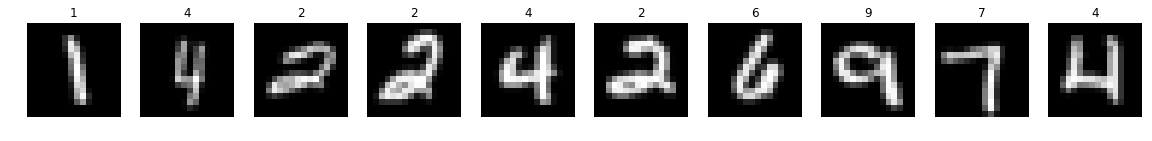

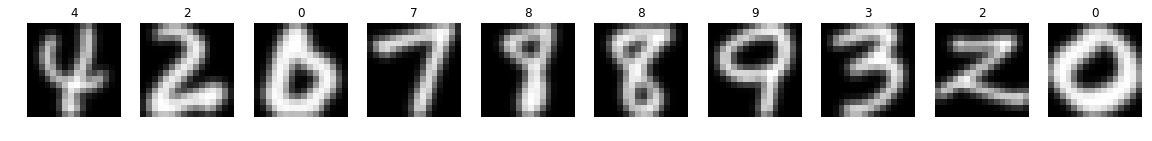

In [6]:
i = 0
ysb.show_labeled_patches_gray(mnist_data.train.images[i:(i+10)], mnist_data.train.cls[i:(i+10)])
ysb.show_labeled_patches_gray(usps_data.train.images[i:(i+10)], usps_data.train.cls[i:(i+10)])

## Train the CNN on MNIST.

First, set up the placeholders.

In [71]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1) # A placeholder only, so calculated instead of passed directly.

Build TensorFlow graph for a simple 3-layer CNN with max-pooling, ReLU and two fully-connected layers.

In [72]:
layer_conv1, weights_conv1 = \
    cn.new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   w_name="conv1_w")
layer_conv2, weights_conv2 = \
    cn.new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   w_name="conv2_w")
layer_conv3, weights_conv3 = \
    cn.new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   w_name="conv3_w")
layer_flat, num_features = cn.flatten_layer(layer_conv3)
layer_fc1 = cn.new_fc_layer(input=layer_flat,                # num_features = 128, from the flattened 3rd layer.
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         w_name="fc1_w")
layer_fc2 = cn.new_fc_layer(input=layer_fc1,                 # This is the classification layer.
                         num_inputs=fc_size,
                         num_outputs=num_classes,            # num_classes = 10
                         use_relu=False,
                         w_name="fc2_w")
y_pred = tf.nn.softmax(layer_fc2)                            # This is the softmax output prediction.
y_pred_cls = tf.argmax(y_pred, dimension=1)                  # The hard classification, with a threshold of 0.5.

In [73]:
# Cost to be reduced is the the cross entropy over all the images.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Now we create a new TensorFlow session and initialise the variables.

In [74]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 128
test_batch_size = 128

saver = tf.train.Saver()

Helper functions for running optimisation iterations and showing test accuracy.

In [75]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(dataset_train, num_iterations, silent=False):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = dataset_train.next_batch(train_batch_size)
        x_batch = x_batch.reshape(len(x_batch), img_size_flat)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 250 iterations.
        if i % 250 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            if not silent:
                msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
                print(msg.format(i + 1, acc))

    total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def print_test_accuracy(dataset_test, show_confusion_matrix=True):
    num_test = len(dataset_test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        
        # Get the images and targets from the test-set between index i and j.
        images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset_test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = dataset_test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy on test set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_confusion_matrix:
        print("Confusion matrix:")
        cn.plot_confusion_matrix(cls_true, cls_pred=cls_pred)
    return acc

Train CNN.

In [76]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 8.0% (1125 / 14000)


0.08035714285714286

In [77]:
optimize(mnist_data.train, num_iterations=2000, silent=True)

Time usage: 0:01:39


In [78]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 91.5% (12811 / 14000)


0.9150714285714285

In [79]:
optimize(mnist_data.train, num_iterations=6000, silent=True)

Time usage: 0:05:07


In [80]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 96.7% (13532 / 14000)


0.9665714285714285

Now we save the CNN model which has been trained on MNIST.

In [81]:
saver.save(sess=session, save_path='checkpoints/')

'checkpoints/'

## Now learn USPS dataset

Now test on USPS test set, then run the CNN on the entire training set (we treat the training set as if it is completely unlabeled) and save softmax outputs.

Accuracy on test set: 60.4% (1122 / 1859)
Confusion matrix:
[[244   0   5   7   0  42   5   0  12   0]
 [  0  59   0   0   0   0   2   0 205   0]
 [  0   0 138  24   0   1   1   0   7   0]
 [  0   0   1 166   0   2   0   0  10   2]
 [  0   0   7   1  86   0  10   7  23  22]
 [  1   0   0  46   0  88   4   0   9   5]
 [  0   0   1   1   0  10 144   0  13   0]
 [  1   8  76   0   0   0   0  35  49   0]
 [  0   0   0   1   0   1   1   0 137   0]
 [  0   0   2   0  19   0   0   9  84  25]]


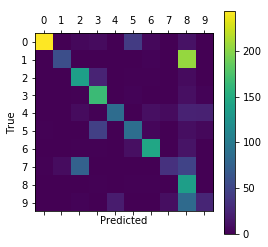

0.6035502958579881

In [82]:
print_test_accuracy(usps_data.test, show_confusion_matrix=True)

In [83]:
def retrieve_predictions(dataset):
    ''' Retrieves the probabilities (not predicted classes) on the given DataSet object. '''
    num_test = len(dataset.images)
    print("Number of images in set: " + str(num_test))

    # Allocate an array for the class probabilities which will be calculated in batches and added
    # onto this array; this first element is a dummy to maintain shape as we will add in batches.
    cls_prob = np.zeros(shape=(1, num_classes), dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        images = dataset.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}

        # Save the softmax output.
        cls_prob = np.concatenate((cls_prob, session.run(y_pred, feed_dict=feed_dict)), axis=0)
        i = j
    
    cls_prob = np.delete(cls_prob, 0, 0) # Remove the first dummy element now.
    return cls_prob

## Experimenting with different thresholds, number of iterations, & threshold rates.

To reset model:

saver.restore(sess=session, save_path='checkpoints/')

In [98]:
data = dataset.generate_combined_dataset(mnist_data, usps_data)

### Experiment 1: repeated iterations of taking the top 0.99.

In [101]:
total_iterations = 50
exp1_acc = []

for i in range(total_iterations):
    print("Experiment 1 Round " + str(i) + ":")
    usps_train_preds = retrieve_predictions(data.usps_train)
    selected = cn.split_by_threshold(0.99, usps_train_preds, silent=True)
    data.train.add_to_set(selected, data.usps_train, usps_train_preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp1_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False))

Experiment 1 Round 0:
Number of images in set: 7439
Images added to set: 2333
Removed 2333 images from dataset.
Updated dataset size: 5106


KeyboardInterrupt: 

In [96]:
print(len(exp1_acc))
print(np.max(exp1_acc))

7
0.630984400215


In [97]:
saver.restore(sess=session, save_path='checkpoints/')

INFO:tensorflow:Restoring parameters from checkpoints/


### Experiment 2: gradually decrease the softmax threshold requirement for re-labelling.

In [44]:
train_preds = retrieve_predictions(data.usps_train)
selected = cn.split_by_threshold(0.99, train_preds)
# Now add the high-confidence images with CNN-predicted labels to training set and remove from usps_train.
data.train.add_to_set(selected, data.usps_train, train_preds)
data.usps_train.remove_from_set(selected)

Number of images in set: 4412
Found 390 images labeled with confidence >= 0.99
Images added to set: 390
Removed 390 images from dataset.
Updated dataset size: 4022


Optimization Iteration:      1, Training Accuracy:  97.7%
Optimization Iteration:    251, Training Accuracy:  99.2%
Time usage: 0:00:22
Accuracy on test set: 72.4% (1346 / 1859)
Confusion matrix:
[[260   0  25  17   0   4   2   0   6   1]
 [  0 150   0   0   0   0   1   0 115   0]
 [  0   7 148  14   0   1   0   0   1   0]
 [  0   0   2 177   0   0   0   0   2   0]
 [  1   0   3   0 129   1   4   3   6   9]
 [  0   0   1  36   0 112   1   0   3   0]
 [  0   0   0   0   1   7 158   0   3   0]
 [  0  18 108   1   0   0   0  35   3   4]
 [  0   0   3   4   0   5   1   0 127   0]
 [  0   0   6   7  18   1   0  17  40  50]]


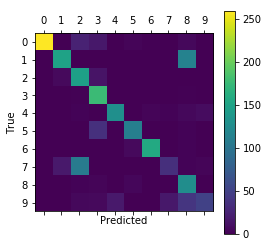

In [45]:
optimize(data.train, num_iterations=500)
print_test_accuracy(data.test, show_confusion_matrix=True)

In [46]:
train_preds = retrieve_predictions(data.usps_train)
selected = cn.split_by_threshold(0.99, train_preds)

data.train.add_to_set(selected, data.usps_train, train_preds)
data.usps_train.remove_from_set(selected)

optimize(data.train, num_iterations=500)
print_test_accuracy(data.test, show_confusion_matrix=False)

Number of images in set: 4022
Found 130 images labeled with confidence >= 0.99
Images added to set: 130
Removed 130 images from dataset.
Updated dataset size: 3892
Optimization Iteration:    501, Training Accuracy:  97.7%
Optimization Iteration:    751, Training Accuracy: 100.0%
Time usage: 0:00:24
Accuracy on test set: 71.3% (1325 / 1859)


In [47]:
train_preds = retrieve_predictions(data.usps_train)
selected = cn.split_by_threshold(0.95, train_preds)

data.train.add_to_set(selected, data.usps_train, train_preds)
data.usps_train.remove_from_set(selected)

optimize(data.train, num_iterations=500)
print_test_accuracy(data.test, show_confusion_matrix=False)

Number of images in set: 3892
Found 665 images labeled with confidence >= 0.95
Images added to set: 665
Removed 665 images from dataset.
Updated dataset size: 3227
Optimization Iteration:   1001, Training Accuracy:  99.2%
Optimization Iteration:   1251, Training Accuracy:  97.7%
Time usage: 0:00:22
Accuracy on test set: 76.2% (1417 / 1859)


## Close TensorFlow session

Releases all resources! Run only when prepared to lose saved CNN model.

In [102]:
session.close()